In [1]:
library(mlr3verse)

Loading required package: mlr3



## Solution 1: HRO in mlr3

In [3]:
#| label: hro-objects

# H: First, initialize your learner.
# Before training learners just contain information on the functional form of f.
model <- lrn("regr.lm")
print(model)
x <- seq(0, 8, by = 0.01)
set.seed(42)
y <- -1 + 3 * x + rnorm(mean = 0, sd = 4, n = length(x))
dt <- data.frame(x = x, y = y)
task <- TaskRegr$new(id = "mytask", backend = dt, target = "y")
# R: `mlr3` relies on package-specific learning objectives.
# O: Optimization is triggered by `model$train()`, internally calling 
# package-specific optimization procedures.
model$train(task)
sprintf("Model MSE: %.4f", model$predict_newdata(dt)$score())

<LearnerRegrLM:regr.lm>
* Model: -
* Parameters: list()
* Packages: mlr3, mlr3learners, stats
* Predict Types:  [response], se
* Feature Types: logical, integer, numeric, character, factor
* Properties: loglik, weights


[1] "Model MSE: 15.1048"

In [4]:
#| label: hro-task

task_iris <- tsk("iris")
sprintf("Feature names: %s", task_iris$feature_names)
sprintf("Target name: %s", task_iris$target_names)

[1] "Feature names: Petal.Length" "Feature names: Petal.Width" 
[3] "Feature names: Sepal.Length" "Feature names: Sepal.Width"

[1] "Target name: Species"

In [8]:
#| label: hro-learner

# List available learners in base mlr3 package
head(mlr_learners$keys())

# Inspect regression tree learner
lrn("regr.rpart")

# List configurable hyperparameters
lrn("regr.rpart")$param_set

[1] "classif.cv_glmnet"   "classif.debug"       "classif.featureless"
[4] "classif.glmnet"      "classif.kknn"        "classif.lda"

<LearnerRegrRpart:regr.rpart>: Regression Tree
* Model: -
* Parameters: xval=0
* Packages: mlr3, rpart
* Predict Types:  [response]
* Feature Types: logical, integer, numeric, factor, ordered
* Properties: importance, missings, selected_features, weights

<ParamSet>
                id    class lower upper nlevels        default value
 1:             cp ParamDbl     0     1     Inf           0.01      
 2:     keep_model ParamLgl    NA    NA       2          FALSE      
 3:     maxcompete ParamInt     0   Inf     Inf              4      
 4:       maxdepth ParamInt     1    30      30             30      
 5:   maxsurrogate ParamInt     0   Inf     Inf              5      
 6:      minbucket ParamInt     1   Inf     Inf <NoDefault[3]>      
 7:       minsplit ParamInt     1   Inf     Inf             20      
 8: surrogatestyle ParamInt     0     1       2              0      
 9:   usesurrogate ParamInt     0     2       3              2      
10:           xval ParamInt     0   Inf     Inf             10     0

## Solution 4: Predicting `abalone`

In [9]:
#| label: abalone-data

# Download data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
abalone <- read.table(url, sep = ",", row.names = NULL)
colnames(abalone) <- c(
  "sex", "longest_shell", "diameter", "height", "whole_weight",
  "shucked_weight", "visceral_weight", "shell_weight", "rings"
)

# Reduce to relevant columns
abalone <- abalone[, c("longest_shell", "whole_weight", "rings")]

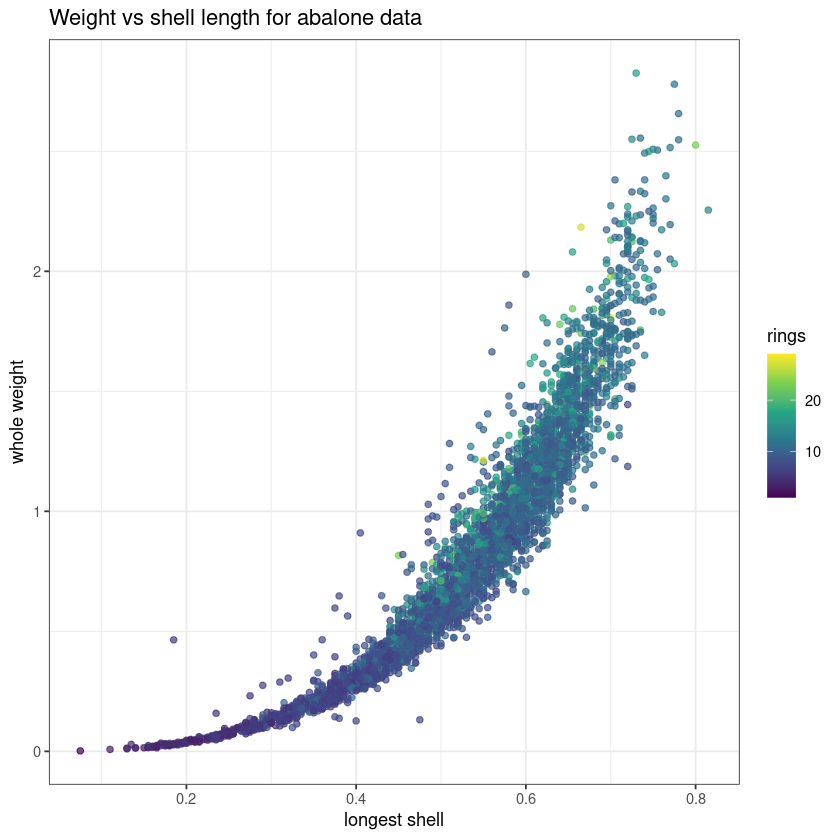

In [16]:
#| label: abalone-plot
#| fig-height: 3
#| fig-width: 3

library(ggplot2)

# Plot weight vs shell length
ggplot(
  abalone,
  aes(x = longest_shell, y = whole_weight, col = rings)) +
  geom_point(alpha = 0.7) +
  scale_color_viridis_c() +
  theme_bw() +
  labs(
    x = "longest shell",
    y = "whole weight",
    title = "Weight vs shell length for abalone data"
  )

In [17]:
#| label: abalone-task

library(mlr3)

# Specify regression task
task_abalone <- TaskRegr$new(
  id = "abalone", backend = abalone, target = "rings"
)
task_abalone

<TaskRegr:abalone> (4177 x 3)
* Target: rings
* Properties: -
* Features (2):
  - dbl (2): longest_shell, whole_weight

In [18]:
#| label: abalone-predict

library(mlr3)
library(mlr3learners)

# Set up LM, train (by default, the target will be regressed on all features,
# i.e., target ~ .)
learner_lm <- mlr3::lrn("regr.lm")
print("Model before training:")
learner_lm$model

# Train and predict
learner_lm$train(task_abalone)
print("Model after training:")
learner_lm$model
pred_lm <- learner_lm$predict(task_abalone)

# Inspect predictions
print("Predictions:")
pred_lm

[1] "Model before training:"


NULL

[1] "Model after training:"



Call:
stats::lm(formula = task$formula(), data = task$data())

Coefficients:
  (Intercept)  longest_shell   whole_weight  
        3.431         10.582          1.155  


[1] "Predictions:"


<PredictionRegr> for 4177 observations:
    row_ids truth  response
          1    15  8.840042
          2     7  7.395659
          3     9  9.821995
---                        
       4175     9 11.139128
       4176    10 11.309553
       4177    12 13.195460

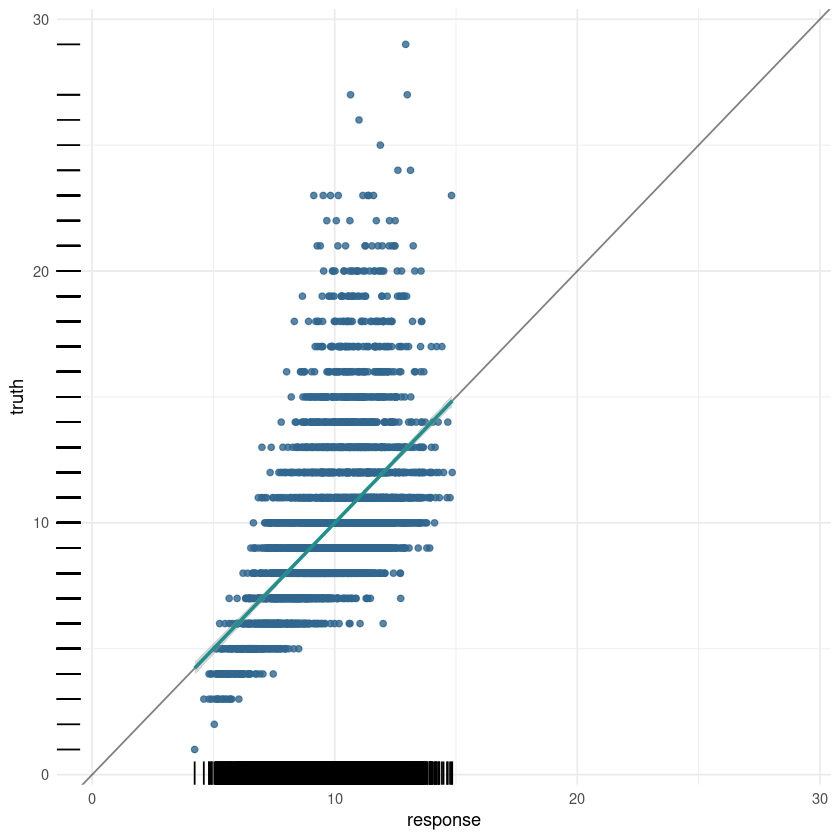

In [19]:
#| label: abalone-viz

library(mlr3viz)

# Get nice visualization with a one-liner
mlr3viz::autoplot(pred_lm) +
  xlim(c(0, max(abalone$rings)))

In [21]:
#| label: abalone-eval

# Define MAE metric
mae <- msr("regr.mae")

# Assess performance (MSE by default)
pred_lm$score()
pred_lm$score(mae)

regr.mse 
7.125521

regr.mae 
 1.95066

In [22]:
# | label: abalone-interpretation

# All effects highly significant
summary(learner_lm$model)


Call:
stats::lm(formula = task$formula(), data = task$data())

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9976 -1.6747 -0.7428  0.9122 16.3478 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     3.4313     0.3156   10.87  < 2e-16 ***
longest_shell  10.5824     0.9071   11.67  < 2e-16 ***
whole_weight    1.1550     0.2221    5.20 2.09e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.67 on 4174 degrees of freedom
Multiple R-squared:  0.3144,	Adjusted R-squared:  0.314 
F-statistic: 956.9 on 2 and 4174 DF,  p-value: < 2.2e-16
